In [76]:
!pip install category_encoders

     |████████████████████████████████| 80 kB 1.3 MB/s eta 0:00:01
  Using cached patsy-0.5.1-py2.py3-none-any.whl (231 kB)
  Using cached statsmodels-0.11.1-cp37-cp37m-macosx_10_13_x86_64.whl (8.4 MB)


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
import pickle
from category_encoders.cat_boost import CatBoostEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, median_absolute_error

In [5]:
import matplotlib.pyplot as plt
plt.style.use(['dark_background'])

In [175]:
train = pd.read_csv('train.csv', index_col=0, float_precision = 32).iloc[:,1:] # Remover coluna com código de inscrição
print('Train Shape:', train.shape)

test = pd.read_csv('test.csv').iloc[:,1:] # Remover coluna com código de inscrição
print('Test Shape:', test.shape)

Train Shape: (13730, 165)
Test Shape: (4576, 46)


# Pre process data

In [226]:
def preProcess(path = None, df_ = None, train = True, save = False,
               save_path = None, pipe_path = 'pipe.pkl'):
    
    # Read Data
    if df_ is None:
        df = pd.read_csv(path, index_col=0)
        if path is None:
            raise ValueError('Must Define path or DataFrame')
    else:
        df = df_.copy()
         
    # Drop when NU_NOTA_LC is null if train
    df.dropna(subset = ['NU_NOTA_LC'], inplace = True)
    
    if train:
        df.dropna(subset = ['NU_NOTA_CN', 'NU_NOTA_CH'], inplace = True)
        
        
    # Create target data if train
    if train:
        try:
            target = df['NU_NOTA_MT']
        except:         
            raise ValueError('Column NU_NOTA_MT missing from data')    
    else:  
        target = None
            
    
    # Columns to select
    cols_select = [
            'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA',
           'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ENSINO',
           'TP_DEPENDENCIA_ADM_ESC', 'CO_PROVA_CH', #'CO_PROVA_LC',
            'CO_PROVA_MT',
           'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
           'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
           'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
           'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'
                  ]
    
    # Select Columsn
    try:      
        df = df[cols_select]
    except:    
        raise ValueError('Column missing from data')
        
     
    # Columns that have floats but are categorical
#     cols_cat = [
#         'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
#         'CO_PROVA_CH', 'CO_PROVA_MT',#'CO_PROVA_LC',
#         'TP_STATUS_REDACAO'
#                ]
    

    
        
    float_cols = [
        'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1','NU_NOTA_COMP2',
        'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5','NU_NOTA_REDACAO',
        'NU_IDADE', 'TP_ANO_CONCLUIU'
    ]   
        
    # Create Pipeline floats
    pipe_float = Pipeline([
        ('inputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ])
    
    # Create Pipeline Categorical Features
    cat_cols = [
        'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CH',#'CO_PROVA_LC',
        'CO_PROVA_MT', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047',
        
        'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
         'TP_STATUS_REDACAO',
        'TP_LINGUA'
    ]
    
    # Convert columns
    df[cat_cols] = df[cat_cols].astype('object')
    
    pipe_cat = Pipeline([
        ('label encoder', CatBoostEncoder())
    ])
    
    # Create full pipeline
    pipe = ColumnTransformer(transformers=[
        ('pipe_float', pipe_float, float_cols),
        ('pipe_cat', pipe_cat, cat_cols)
    ]#, remainder = 'passthrough'
                            )
    
    pipe_target = Pipeline(
        [('scaler', StandardScaler())]
    )
    
    
    # Fit pipelines
    if train:
        
        pipe.fit(df, target)
        
        pipe_target.fit(target.values.reshape(-1,1))
        
        with open(pipe_path, 'wb') as f:
            
            pickle.dump([pipe, pipe_target], f)
            
    else:
        
        with open(pipe_path, 'rb') as f:
            
            pipe, pipe_target = pickle.load(f)
    
    
    # Transform variables
    df = pipe.transform(df)
    
    if train:
    
        target = pipe_target.transform(target.values.reshape(-1,1))
     
    # Save file to pickle
    if save_path is not None:
        with open(save_path, 'wb') as f:
            pickle.dump([df, target], f)
        
    return [df, target]

In [169]:
preProcess('train.csv', save_path='preprocessed.pkl')

[array([[-5.29046160e-01, -4.75297934e-01,  9.42952705e-01, ...,
          2.40000000e+01,  4.00000000e+00,  1.00000000e+00],
        [ 8.26347525e-03,  1.87064802e-01,  1.20303752e+00, ...,
          1.70000000e+01,  0.00000000e+00,  1.00000000e+00],
        [-4.81222789e-01,  7.18859113e-01, -1.54538684e+00, ...,
          1.80000000e+01,  1.00000000e+00,  0.00000000e+00],
        ...,
        [-1.88656286e-01, -1.96685365e-02,  7.69075778e-01, ...,
          1.50000000e+01,  0.00000000e+00,  0.00000000e+00],
        [-7.23152782e-01,  1.24249290e+00,  7.64692327e-01, ...,
          3.60000000e+01,  0.00000000e+00,  1.00000000e+00],
        [ 2.07996376e-01,  6.11412181e-01,  7.19396657e-01, ...,
          1.70000000e+01,  0.00000000e+00,  0.00000000e+00]]),
 array([[-0.83515149],
        [-0.22921785],
        [-1.18526877],
        ...,
        [-0.84919631],
        [-0.96356126],
        [-0.53920708]])]

# Fit models

In [227]:
def fit_models(features, target, models_path = 'models.pkl'):
    
    lm = LinearRegression()
    
    lm = lm.fit(X = features, y = target)
    
    # Store models
    models = {'Linear Model': lm}
    with open(models_path, 'wb') as f:
        pickle.dump(models, f)
        
    return models

In [269]:
def fit_model(model, x_train, x_test, y_train, y_test, **kwargs):
    
    model = model.fit(x_train, y_train, **kwargs)
    
    predictions = make_predictions_sigle(features = x_test, model = model)
    
    metrics, eval_predictions(target = y_test, predictions = predictions)
    
    return model, metrics

In [1]:
from catboost import CatBoostRegressor, Pool
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings("ignore")

In [329]:
!python --version

Python 3.7.0


In [314]:
!pip install numpy==1.18.1

  Using cached numpy-1.18.1-cp37-cp37m-macosx_10_9_x86_64.whl (15.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.1
    Uninstalling numpy-1.16.1:
      Successfully uninstalled numpy-1.16.1


In [321]:
!pip install pandas==0.24.0

     |████████████████████████████████| 15.9 MB 6.8 MB/s eta 0:00:011     |███████████████████████████▎    | 13.5 MB 10.6 MB/s eta 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3


In [324]:
!pip install cycler==0.10

In [325]:
!pip install pytz==2017.2

     |████████████████████████████████| 484 kB 1.3 MB/s eta 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2018.4
    Uninstalling pytz-2018.4:
      Successfully uninstalled pytz-2018.4


In [319]:
!pip install catboost -U

  Using cached catboost-0.23.2-cp37-none-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (10.9 MB)
  Attempting uninstall: catboost
    Found existing installation: catboost 0.22
    Uninstalling catboost-0.22:
      Successfully uninstalled catboost-0.22


In [333]:
!pip install scipy==1.1.0

  Using cached scipy-1.1.0-cp37-cp37m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl (16.7 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [308]:
!pip install cython==0.28.3

     |████████████████████████████████| 5.3 MB 1.3 MB/s eta 0:00:01


In [35]:
def create_models(features, target, models_path = 'models.pkl', pipe_path = 'pipe.pkl', test_size = .25, ):
    
    models = {
        'Linear Model': LinearRegression(), 
        'Catboost': CatBoostRegressor(
            iterations = 500,
            loss_function='RMSE',
            random_state = 1,
            learning_rate=0.01,
            depth=4,
            l2_leaf_reg=0.1,
        
            ),
        'Random Forrest': RandomForestRegressor(n_estimators= 1000, max_depth = 8, random_state = 1),
        
    }
    
    kwargs = {i:{} for i in models}
    kwargs['Catboost'] = {'verbose': 0}
    
    models_fit = {}
    
    metrics = {}
    
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = test_size)
    
    with open(pipe_path, 'rb') as f:
        
        pipe, pipe_target = pickle.load(f)
        
    y_test = pipe_target.inverse_transform(y_test)
    
    for i in tqdm(models):
        
        print(f'>>>> {i}')
        
        models_fit[i] = models[i].fit(x_train, y_train, **kwargs[i])
        
        predictions = make_predictions_sigle(
            model = models_fit[i], features = x_test, transform_back_target = True, pipe_path = pipe_path)
        
        metrics[i] = eval_predictions(y_test, predictions)
        
    with open(models_path, 'wb') as f:
        
        pickle.dump(obj = [models_fit, metrics], file = f)
        
    return [models_fit, metrics]

  0%|          | 0/3 [00:00<?, ?it/s]

>>>> Linear Model
MSE: 5762.041
RMSE: 75.908
Max Error: 437.702
Median Absolute Error: 437.702


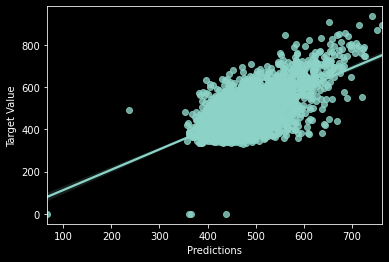

 33%|███▎      | 1/3 [00:00<00:01,  1.88it/s]

>>>> Catboost
MSE: 5607.656
RMSE: 74.884
Max Error: 444.673
Median Absolute Error: 444.673


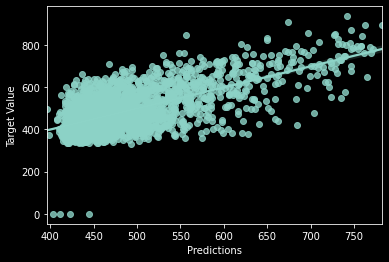

 67%|██████▋   | 2/3 [00:02<00:00,  1.14it/s]

>>>> Random Forrest
MSE: 5568.325
RMSE: 74.621
Max Error: 451.078
Median Absolute Error: 451.078


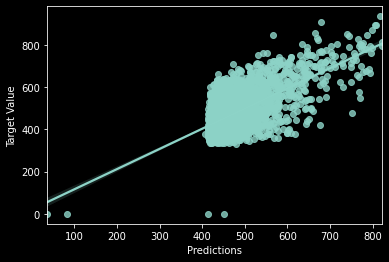

100%|██████████| 3/3 [00:29<00:00,  9.80s/it]


In [36]:
models, metrics = create_models(data, target)

In [80]:
def train_wraper(file_path = 'train.csv', return_arg = False):
    
    features, target = preProcess(path = file_path)
    
    models, metrics = create_models(features, target)
    
    if return_arg:
    
        return models, metrics
    
    

# Make Predictions

In [10]:
# Make predictions for single model
def make_predictions_sigle(features, model, pipe_path = 'pipe.pkl', transform_back_target = True):
    
    forecast = model.predict(features)
    
    with open(pipe_path, 'rb') as f:
        
        pipe, pipe_target = pickle.load(f)
        
    if transform_back_target:
        
        forecast = pipe_target.inverse_transform(forecast)
    
    return forecast
    
    

In [58]:
def predictions_ensemble(features, models, metrics = None, ensamble_method = None, pipe_path = 'pipe.pkl'):
    predictions = {}
    
    for i in models:
        
        predictions[i] = make_predictions_sigle(features, models[i], pipe_path = 'pipe.pkl', transform_back_target = True)
        
    if ensamble_method is not None:
        
        predictions = ensamble_method(predictions)
        
    return predictions
    

In [72]:
def ensamble_method(predictions):
    
    for i in predictions:
        
        if len(predictions[i].shape) > 1:
            
            predictions[i] = predictions[i].reshape(-1)
    
    return pd.DataFrame(predictions).mean(axis = 1)
    

In [73]:
p = predictions_ensemble(data, models, ensamble_method=ensamble_method)

# Eval Predictions

In [12]:
def eval_predictions(target, predictions, verbose = True, plot = True):
    
    out = {}
    
    out['MSE'] = mean_squared_error(target, predictions)
    
    out['RMSE'] = out['MSE'] ** 0.5
    
    out['MAE'] = mean_squared_error(target, predictions)
    
    out['Max Error'] = max_error(target, predictions)
    
    out['Median Absolute Error'] = median_absolute_error(target, predictions)
    
    if verbose:
        
        print(f'MSE: {round(out["MSE"],3)}')
        print(f'RMSE: {round(out["RMSE"],3)}')
        print(f'Max Error: {round(out["Max Error"],3)}')
        print(f'Median Absolute Error: {round(out["Max Error"],3)}')
        
    if plot:
        
        ax = sns.regplot(x = predictions.reshape(-1), y = target.reshape(-1), )
        
        ax.set(xlabel='Predictions', ylabel='Target Value')
        
        plt.show()
    
    
    return out

# Make full predictions

In [184]:
def make_predictions_wraper(file_path = 'test.csv', df_ = None, return_predictions = False, save_name = None):
    
    # Select the ones who missed the test
    if df_ is None:
        df = pd.read_csv(file_path, index_col='NU_INSCRICAO')
    else:
        df = df_.copy()

    zeros = df.isnull().query('NU_NOTA_LC')[[]]
    zeros['NU_NOTA_MT'] = 0
    
    # Get ID of columns to be predicted
    predictions = df[['NU_NOTA_LC']].dropna()[[]]#.index
    
    # Load data
    if df_ is None:
        features, pipe = preProcess(path = file_path, train = False)
    else:
        features, pipe = preProcess(df_ = df_, train = False)
    
    # Load models
    try:

        with open('models.pkl', 'rb') as f:
            models, metrics = pickle.load(f)
    except:

        raise ValueError('Model File Missing')
    
    # Make predictions
    predictions['NU_NOTA_MT'] = predictions_ensemble(features, models, ensamble_method = ensamble_method).values
    
    predictions_full = pd.concat([zeros, predictions])
    
    if save_name is not None:
        
        predictions_full.to_csv(save_name)
        
    if return_predictions:
    
        return predictions_full

In [160]:
file_path = 'test.csv'
make_predictions_wraper(save_name = 'answer.csv')


In [13]:
data, target = preProcess(path = 'train.csv')

In [197]:
data, target = preProcess(path = 'train.csv', train = False)

In [215]:
models = fit_models(data, target)

In [219]:
models[0].predict

<bound method LinearModel.predict of LinearRegression()>

In [233]:
pred = make_predictions_sigle(data, models[0])

In [181]:
train['NU_IDADE'].dtype == 'int64'

True

In [182]:
int(train['NU_IDADE'].min())

13

In [183]:
data.shape

(10097, 31)

In [191]:
train['TP_ENSINO'].astype()

2       1.0
7       1.0
9       1.0
12      1.0
18      1.0
21      1.0
28      3.0
29      1.0
32      1.0
33      1.0
34      1.0
36      1.0
37      1.0
38      1.0
43      1.0
44      1.0
47      1.0
50      1.0
55      1.0
62      1.0
66      1.0
69      1.0
76      1.0
77      1.0
78      1.0
84      1.0
87      1.0
89      1.0
93      1.0
96      1.0
       ... 
4495    1.0
4505    1.0
4506    1.0
4512    1.0
4513    1.0
4517    1.0
4519    1.0
4522    1.0
4524    1.0
4525    1.0
4528    1.0
4529    1.0
4535    1.0
4537    1.0
4541    1.0
4542    2.0
4545    1.0
4546    1.0
4548    1.0
4551    1.0
4552    3.0
4557    1.0
4558    1.0
4563    1.0
4564    1.0
4571    1.0
4574    1.0
4577    1.0
4578    1.0
4586    1.0
Name: TP_ENSINO, Length: 4282, dtype: float64

In [202]:
float_cols = [
        'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_COMP1','NU_NOTA_COMP2',
        'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5','NU_NOTA_REDACAO',
        'NU_IDADE', 'TP_ANO_CONCLUIU'
    ]  

In [203]:
cat_cols = [
        'SG_UF_RESIDENCIA', 'TP_SEXO', 'CO_PROVA_CH','CO_PROVA_LC',
        'CO_PROVA_MT', 'Q001', 'Q002', 'Q006', 'Q024', 'Q025',
       'Q026', 'Q027', 'Q047',
        
        'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
         'TP_STATUS_REDACAO'
    ]

In [204]:
len(float_cols) + len(cat_cols)

30

In [205]:
cols_select = [
            'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA',
           'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ENSINO',
           'TP_DEPENDENCIA_ADM_ESC', 'CO_PROVA_CH', #'CO_PROVA_LC', 
            'CO_PROVA_MT',
           'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
           'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
           'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
           'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'
                  ]

In [206]:
len(cols_select)

30

In [195]:
train['TP_ENSINO'].tolist().index(1)

1

In [222]:
make_predictions_wraper(file_path='st.csv')

ValueError: Index NU_INSCRICAO invalid

In [212]:
preProcess('train.csv')

[array([[-5.29046160e-01, -4.75297934e-01,  9.42952705e-01, ...,
          2.40000000e+01,  4.00000000e+00,  1.00000000e+00],
        [ 8.26347525e-03,  1.87064802e-01,  1.20303752e+00, ...,
          1.70000000e+01,  0.00000000e+00,  1.00000000e+00],
        [-4.81222789e-01,  7.18859113e-01, -1.54538684e+00, ...,
          1.80000000e+01,  1.00000000e+00,  0.00000000e+00],
        ...,
        [-1.88656286e-01, -1.96685365e-02,  7.69075778e-01, ...,
          1.50000000e+01,  0.00000000e+00,  0.00000000e+00],
        [-7.23152782e-01,  1.24249290e+00,  7.64692327e-01, ...,
          3.60000000e+01,  0.00000000e+00,  1.00000000e+00],
        [ 2.07996376e-01,  6.11412181e-01,  7.19396657e-01, ...,
          1.70000000e+01,  0.00000000e+00,  0.00000000e+00]]),
 array([[-0.83515149],
        [-0.22921785],
        [-1.18526877],
        ...,
        [-0.84919631],
        [-0.96356126],
        [-0.53920708]])]

In [227]:
preProcess('st.csv', train = False)

[array([[-1.98502274e-01,  2.24941838e-02,  6.18788686e-02,
          4.01898488e-03,  2.37626611e-01,  3.81828103e-01,
          2.03213185e-01,  5.90368317e-02,  6.84901732e-02,
         -2.48311778e-01, -5.98795477e-01,  5.03964024e+02,
          4.68280838e+02,  4.82648638e+02,  4.82648638e+02,
          4.57279217e+02,  4.93554158e+02,  4.49338311e+02,
          4.93301680e+02,  5.03628032e+02,  4.83678004e+02,
          4.78666557e+02,  4.67454694e+02,  4.68839556e+02,
          4.83742356e+02,  4.91322221e+02,  4.82478605e+02,
          4.60616438e+02,  4.83634403e+02,  4.65476175e+02]]), None]

In [233]:
preProcess(df_ = d, train = False)

[array([[-1.98502274e-01,  2.24941838e-02,  6.18788686e-02,
          4.01898488e-03,  2.37626611e-01,  3.81828103e-01,
          2.03213185e-01,  5.90368317e-02,  6.84901732e-02,
         -2.48311778e-01, -5.98795477e-01,  5.03964024e+02,
          4.68280838e+02,  4.82648638e+02,  4.82648638e+02,
          4.57279217e+02,  4.93554158e+02,  4.49338311e+02,
          4.93301680e+02,  5.03628032e+02,  4.83678004e+02,
          4.78666557e+02,  4.67454694e+02,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan]]), None]

In [240]:
d = pd.read_csv('st.csv', index_col=0)

In [230]:
d

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,CO_PROVA_CH,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,SP,19.0,F,3,1,1,0.0,1.0,2.0,2d22ac1d42e6187f09ee6c578df187a760123ccf,...,80.0,540.0,B,E,B,B,B,A,F,A


In [236]:
from io import StringIO

In [238]:
pd.read_csv(StringIO(d.to_string()), sep=";")

,SG_UF_RESIDENCIA NU_IDADE TP_SEXO TP_COR_RACA TP_NACIONALIDADE TP_ST_CONCLUSAO TP_ANO_CONCLUIU TP_ENSINO TP_DEPENDENCIA_ADM_ESC CO_PROVA_CH CO_PROVA_MT NU_NOTA_CN NU_NOTA_CH NU_NOTA_LC TP_LINGUA TP_STATUS_REDACAO NU_NOTA_COMP1 NU_NOTA_COMP2 NU_NOTA_COMP3 NU_NOTA_COMP4 NU_NOTA_COMP5 NU_NOTA_REDACAO Q001 Q002 Q006 Q024 Q025 Q026 Q027 Q047
0,0 SP 19.0 F ...


In [239]:
d.to_string()

'  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO TP_COR_RACA TP_NACIONALIDADE TP_ST_CONCLUSAO  TP_ANO_CONCLUIU TP_ENSINO TP_DEPENDENCIA_ADM_ESC                               CO_PROVA_CH                               CO_PROVA_MT  NU_NOTA_CN  NU_NOTA_CH  NU_NOTA_LC TP_LINGUA TP_STATUS_REDACAO  NU_NOTA_COMP1  NU_NOTA_COMP2  NU_NOTA_COMP3  NU_NOTA_COMP4  NU_NOTA_COMP5  NU_NOTA_REDACAO Q001 Q002 Q006 Q024 Q025 Q026 Q027 Q047\n0               SP      19.0       F           3                1               1              0.0       1.0                    2.0  2d22ac1d42e6187f09ee6c578df187a760123ccf  2d22ac1d42e6187f09ee6c578df187a760123ccf       459.8       532.0       520.9         1               1.0          120.0          120.0          120.0          120.0           80.0            540.0    B    E    B    B    B    A    F    A'

In [246]:
e = pd.read_pickle('st.pkl')

In [247]:
d.dtypes

SG_UF_RESIDENCIA           object
NU_IDADE                  float64
TP_SEXO                    object
TP_COR_RACA                 int64
TP_NACIONALIDADE            int64
TP_ST_CONCLUSAO             int64
TP_ANO_CONCLUIU           float64
TP_ENSINO                 float64
TP_DEPENDENCIA_ADM_ESC    float64
CO_PROVA_CH                object
CO_PROVA_MT                object
NU_NOTA_CN                float64
NU_NOTA_CH                float64
NU_NOTA_LC                float64
TP_LINGUA                   int64
TP_STATUS_REDACAO         float64
NU_NOTA_COMP1             float64
NU_NOTA_COMP2             float64
NU_NOTA_COMP3             float64
NU_NOTA_COMP4             float64
NU_NOTA_COMP5             float64
NU_NOTA_REDACAO           float64
Q001                       object
Q002                       object
Q006                       object
Q024                       object
Q025                       object
Q026                       object
Q027                       object
Q047          

In [248]:
e.dtypes

SG_UF_RESIDENCIA           object
NU_IDADE                  float64
TP_SEXO                    object
TP_COR_RACA                 int64
TP_NACIONALIDADE            int64
TP_ST_CONCLUSAO             int64
TP_ANO_CONCLUIU           float64
TP_ENSINO                  object
TP_DEPENDENCIA_ADM_ESC     object
CO_PROVA_CH                object
CO_PROVA_MT                object
NU_NOTA_CN                float64
NU_NOTA_CH                float64
NU_NOTA_LC                float64
TP_LINGUA                   int64
TP_STATUS_REDACAO          object
NU_NOTA_COMP1             float64
NU_NOTA_COMP2             float64
NU_NOTA_COMP3             float64
NU_NOTA_COMP4             float64
NU_NOTA_COMP5             float64
NU_NOTA_REDACAO           float64
Q001                       object
Q002                       object
Q006                       object
Q024                       object
Q025                       object
Q026                       object
Q027                       object
Q047          

In [249]:
d.dtypes != e.dtypes

SG_UF_RESIDENCIA          False
NU_IDADE                  False
TP_SEXO                   False
TP_COR_RACA               False
TP_NACIONALIDADE          False
TP_ST_CONCLUSAO           False
TP_ANO_CONCLUIU           False
TP_ENSINO                  True
TP_DEPENDENCIA_ADM_ESC     True
CO_PROVA_CH               False
CO_PROVA_MT               False
NU_NOTA_CN                False
NU_NOTA_CH                False
NU_NOTA_LC                False
TP_LINGUA                 False
TP_STATUS_REDACAO          True
NU_NOTA_COMP1             False
NU_NOTA_COMP2             False
NU_NOTA_COMP3             False
NU_NOTA_COMP4             False
NU_NOTA_COMP5             False
NU_NOTA_REDACAO           False
Q001                      False
Q002                      False
Q006                      False
Q024                      False
Q025                      False
Q026                      False
Q027                      False
Q047                      False
dtype: bool